# BLIP

batch=8 epoch=30

accuracy: 0.8108  
val_accuracy: 0.7390        
Precision: 0.4715  
Recall: 0.4374  
F1-Score: 0.4420  
Weighted F1-Score: 0.6430     

In [1]:
pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.1 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
Note: you may need to restart the kernel to use updated packages.


In [2]:
import transformers
print(transformers.__version__)

4.48.3


In [1]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch import nn
import torch.optim as optim
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

class BLIPSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.num_classes = num_classes
        self.processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        
        for param in self.blip.parameters():
            param.requires_grad = False
            
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),  # BLIP base hidden size is 768
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image_inputs, text_inputs):
        outputs = self.blip(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            pixel_values=image_inputs['pixel_values'],
            return_dict=True
        )
        
        # Get image features
        image_features = outputs.image_embeds[:, 0]  # [CLS] token
        return self.classifier(image_features)

def process_data_batch(image_paths, texts, processor, batch_size=8, device='cuda'):
    all_image_inputs = []
    all_text_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        inputs = processor(
            images=batch_images,
            text=batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        
        all_image_inputs.append({
            'pixel_values': inputs['pixel_values'].to(device)
        })
        all_text_inputs.append({
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device)
        })
    
    return all_image_inputs, all_text_inputs

def evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device='cuda'):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            probabilities = torch.softmax(outputs, dim=1)
            all_predictions.extend(probabilities.cpu().numpy())
            all_labels.extend(test_labels[i * batch_size:(i + 1) * batch_size].cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    precision = precision_score(all_labels, predicted_labels, average='macro')
    recall = recall_score(all_labels, predicted_labels, average='macro')
    f1 = f1_score(all_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(all_labels, predicted_labels, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve
    y_test_one_hot = np.eye(len(label_map))[all_labels]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], all_predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, all_predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")

    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], all_predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, 
                device='cuda', epochs=30, batch_size=8):
    
    print("Initializing model...")
    model = BLIPSentimentModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.02)
    criterion = nn.CrossEntropyLoss()
    
    print("Processing training data...")
    train_image_inputs, train_text_inputs = process_data_batch(
        train_image_paths, train_texts, model.processor, batch_size=batch_size, device=device
    )
    
    print("Processing validation data...")
    val_image_inputs, val_text_inputs = process_data_batch(
        val_image_paths, val_texts, model.processor, batch_size=batch_size, device=device
    )
    
    train_labels = torch.tensor(train_labels, device=device)
    val_labels = torch.tensor(val_labels, device=device)
    
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(len(train_image_inputs)):
            optimizer.zero_grad()
            outputs = model(train_image_inputs[i], train_text_inputs[i])
            batch_labels = train_labels[i * batch_size:(i + 1) * batch_size]
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
        
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for i in range(len(val_image_inputs)):
                outputs = model(val_image_inputs[i], val_text_inputs[i])
                batch_labels = val_labels[i * batch_size:(i + 1) * batch_size]
                
                _, predicted = outputs.max(1)
                val_total += batch_labels.size(0)
                val_correct += predicted.eq(batch_labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        print(f'Epoch {epoch + 1}: Train Acc: {100.*correct/total:.2f}% Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def main():
    print("Installing required packages...")
    try:
        import subprocess
        subprocess.check_call(["pip", "install", "--upgrade", "transformers", "torch", "torchvision"])
    except:
        print("Warning: Could not install packages. Please ensure they are installed manually.")
        
    batch_size = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("Loading data...")
    train_df = pd.read_csv('/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/train.csv')
    test_df = pd.read_csv('/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/test.csv')
    
    memes_folder = '/kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes'
    train_image_paths = [os.path.join(memes_folder, img) for img in train_df['image_name']]
    test_image_paths = [os.path.join(memes_folder, img) for img in test_df['image_name']]
    
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    train_labels = np.array([label_map[label] for label in train_df['Label_Sentiment']])
    
    train_paths, val_paths, train_texts, val_texts, train_labs, val_labs = train_test_split(
        train_image_paths, train_df['Captions'].tolist(),
        train_labels, test_size=0.15,
        random_state=42, stratify=train_labels
    )
    
    model = train_model(
        train_paths, train_texts, train_labs,
        val_paths, val_texts, val_labs,
        device=device,
        batch_size=batch_size
    )
    
    print("Processing test data...")
    test_image_inputs, test_text_inputs = process_data_batch(
        test_image_paths, test_df['Captions'].tolist(),
        model.processor, batch_size=batch_size, device=device
    )
    
    test_labels = np.array([label_map[label] for label in test_df['Label_Sentiment']])
    test_labels = torch.tensor(test_labels, device=device)

    # Evaluate the model
    evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device=device)

    # Save predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predictions]
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")

if __name__ == "__main__":
    main()

Installing required packages...
Loading data...
Initializing model...
Processing training data...
Error loading image /kaggle/input/multimodal-sentiment-analysis-cuet-nlp/Memes/Memes/nurani-memes (149).jpg: image file is truncated (1 bytes not processed)
Processing validation data...
Epoch 1: Train Acc: 58.86% Val Acc: 63.05%
Epoch 2: Train Acc: 63.84% Val Acc: 64.57%
Epoch 3: Train Acc: 66.77% Val Acc: 69.33%
Epoch 4: Train Acc: 68.38% Val Acc: 71.43%
Epoch 5: Train Acc: 69.80% Val Acc: 72.00%
Epoch 6: Train Acc: 70.94% Val Acc: 71.62%
Epoch 7: Train Acc: 71.52% Val Acc: 72.95%
Epoch 8: Train Acc: 72.59% Val Acc: 73.33%
Epoch 9: Train Acc: 72.79% Val Acc: 73.52%
Epoch 10: Train Acc: 73.77% Val Acc: 73.71%
Epoch 11: Train Acc: 73.47% Val Acc: 73.71%
Epoch 12: Train Acc: 73.54% Val Acc: 73.71%
Epoch 13: Train Acc: 74.95% Val Acc: 73.90%
Epoch 14: Train Acc: 75.19% Val Acc: 73.33%
Epoch 15: Train Acc: 74.75% Val Acc: 73.71%
Epoch 16: Train Acc: 75.62% Val Acc: 73.52%
Epoch 17: Train Acc:

KeyError: 'Label_Sentiment'

In [8]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch import nn
import torch.optim as optim
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class BLIPSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.num_classes = num_classes
        self.processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        
        for param in self.blip.parameters():
            param.requires_grad = False
            
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),  # BLIP base hidden size is 768
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image_inputs, text_inputs):
        outputs = self.blip(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            pixel_values=image_inputs['pixel_values'],
            return_dict=True
        )
        
        # Get image features
        image_features = outputs.image_embeds[:, 0]  # [CLS] token
        return self.classifier(image_features)

def process_data_batch(image_paths, texts, processor, batch_size=8, device='cuda'):
    all_image_inputs = []
    all_text_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        inputs = processor(
            images=batch_images,
            text=batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        
        all_image_inputs.append({
            'pixel_values': inputs['pixel_values'].to(device)
        })
        all_text_inputs.append({
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device)
        })
    
    return all_image_inputs, all_text_inputs

def evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device='cuda'):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            probabilities = torch.softmax(outputs, dim=1)
            all_predictions.extend(probabilities.cpu().numpy())
            all_labels.extend(test_labels[i * batch_size:(i + 1) * batch_size].cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    precision = precision_score(all_labels, predicted_labels, average='macro')
    recall = recall_score(all_labels, predicted_labels, average='macro')
    f1 = f1_score(all_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(all_labels, predicted_labels, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve
    y_test_one_hot = np.eye(len(label_map))[all_labels]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], all_predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, all_predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")

    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], all_predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, 
                device='cuda', epochs=20, batch_size=8):
    
    print("Initializing model...")
    model = BLIPSentimentModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.02)
    criterion = nn.CrossEntropyLoss()
    
    print("Processing training data...")
    train_image_inputs, train_text_inputs = process_data_batch(
        train_image_paths, train_texts, model.processor, batch_size=batch_size, device=device
    )
    
    print("Processing validation data...")
    val_image_inputs, val_text_inputs = process_data_batch(
        val_image_paths, val_texts, model.processor, batch_size=batch_size, device=device
    )
    
    train_labels = torch.tensor(train_labels, device=device)
    val_labels = torch.tensor(val_labels, device=device)
    
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(len(train_image_inputs)):
            optimizer.zero_grad()
            outputs = model(train_image_inputs[i], train_text_inputs[i])
            batch_labels = train_labels[i * batch_size:(i + 1) * batch_size]
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
        
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for i in range(len(val_image_inputs)):
                outputs = model(val_image_inputs[i], val_text_inputs[i])
                batch_labels = val_labels[i * batch_size:(i + 1) * batch_size]
                
                _, predicted = outputs.max(1)
                val_total += batch_labels.size(0)
                val_correct += predicted.eq(batch_labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        print(f'Epoch {epoch + 1}: Train Acc: {100.*correct/total:.2f}% Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def main():
    print("Installing required packages...")
    try:
        import subprocess
        subprocess.check_call(["pip", "install", "--upgrade", "transformers", "torch", "torchvision"])
    except:
        print("Warning: Could not install packages. Please ensure they are installed manually.")
        
    batch_size = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("Loading data...")
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return

    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/memosen-with-label/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())

    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Split images into train test set
    train_paths, val_paths, train_texts, val_texts, train_labs, val_labs = train_test_split(
        train_image_paths, train_df['Captions'].tolist(),
        train_labels, test_size=0.2,
        random_state=42, stratify=train_labels
    )

    # Handle class imbalance
    # class_weights = compute_class_weight(
    #     class_weight='balanced',
    #     classes=np.unique(train_labels),
    #     y=train_labels
    # )
    # class_weights = dict(enumerate(class_weights))
    
    # Train model
    model = train_model(
        train_paths, train_texts, train_labs,
        val_paths, val_texts, val_labs,
        device=device,
        batch_size=batch_size
    )
    
    print("Processing test data...")
    test_image_inputs, test_text_inputs = process_data_batch(
        test_image_paths, test_df['Captions'].tolist(),
        model.processor, batch_size=batch_size, device=device
    )
    
    test_labels = np.array([label_map[label] for label in test_df['Label_Sentiment']])
    test_labels = torch.tensor(test_labels, device=device)

    # Evaluate the model
    evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device=device)

    # Save predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predictions]
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")

if __name__ == "__main__":
    main()

Installing required packages...
Loading data...
Combined DataFrame Columns: Index(['image_name', 'Captions', 'Label_Sentiment'], dtype='object')
Number of missing values in 'Label_Sentiment': 12
Unique values in 'Label_Sentiment': ['positive' 'negative' 'neutral' nan]
Initializing model...
Processing training data...
Error loading image /kaggle/input/memosen-with-label/Memes/KAM (128) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/memosen-with-label/Memes/KAM (128) (1).jpg'
Processing validation data...
Epoch 1: Train Acc: 56.67% Val Acc: 62.43%
Epoch 2: Train Acc: 62.89% Val Acc: 64.86%
Epoch 3: Train Acc: 66.00% Val Acc: 68.57%
Epoch 4: Train Acc: 67.29% Val Acc: 69.29%
Epoch 5: Train Acc: 68.43% Val Acc: 70.14%
Epoch 6: Train Acc: 69.07% Val Acc: 70.71%
Epoch 7: Train Acc: 70.93% Val Acc: 71.57%
Epoch 8: Train Acc: 71.76% Val Acc: 71.57%
Epoch 9: Train Acc: 71.68% Val Acc: 71.43%
Epoch 10: Train Acc: 72.29% Val Acc: 71.71%
Epoch 11: Train Acc: 72.54% Val Acc: 71.86%
Ep

KeyError: 'Label_Sentiment'

# BLIP

batch=8 epoch=15

accuracy: 0.7508    
val_accuracy: 0.7314          
Precision: 0.4748  
Recall: 0.4800  
F1-Score: 0.4728  
Weighted F1-Score: 0.6913       

Installing required packages...
Loading data...
Combined DataFrame Columns: Index(['image_name', 'Captions', 'Label_Sentiment'], dtype='object')
Number of missing values in 'Label_Sentiment': 12
Unique values in 'Label_Sentiment': ['positive' 'negative' 'neutral' nan]
Initializing model...
Processing training data...
Error loading image /kaggle/input/memosen-with-label/Memes/KAM (128) (1).jpg: [Errno 2] No such file or directory: '/kaggle/input/memosen-with-label/Memes/KAM (128) (1).jpg'
Processing validation data...
Epoch 1: Train Acc: 59.92% Val Acc: 62.43%
Epoch 2: Train Acc: 64.68% Val Acc: 66.29%
Epoch 3: Train Acc: 66.57% Val Acc: 68.43%
Epoch 4: Train Acc: 68.32% Val Acc: 70.00%
Epoch 5: Train Acc: 69.36% Val Acc: 71.14%
Epoch 6: Train Acc: 70.25% Val Acc: 71.43%
Epoch 7: Train Acc: 70.83% Val Acc: 71.71%
Epoch 8: Train Acc: 72.08% Val Acc: 71.71%
Epoch 9: Train Acc: 72.40% Val Acc: 71.71%
Epoch 10: Train Acc: 73.01% Val Acc: 72.14%
Epoch 11: Train Acc: 73.08% Val Acc: 72.43%
Ep

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.4748
Recall: 0.4800
F1-Score: 0.4728
Weighted F1-Score: 0.6913


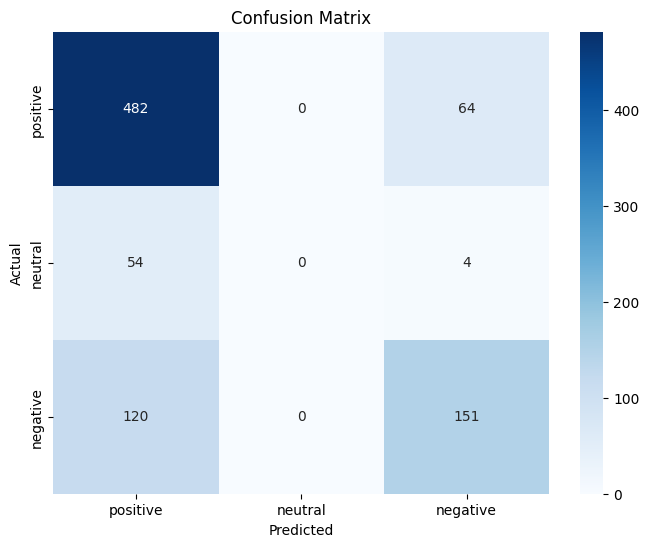

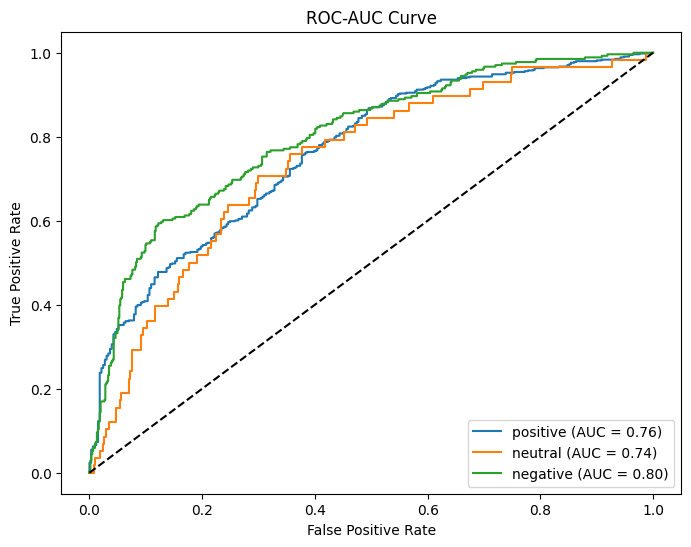

Macro-average ROC-AUC Score: 0.7683


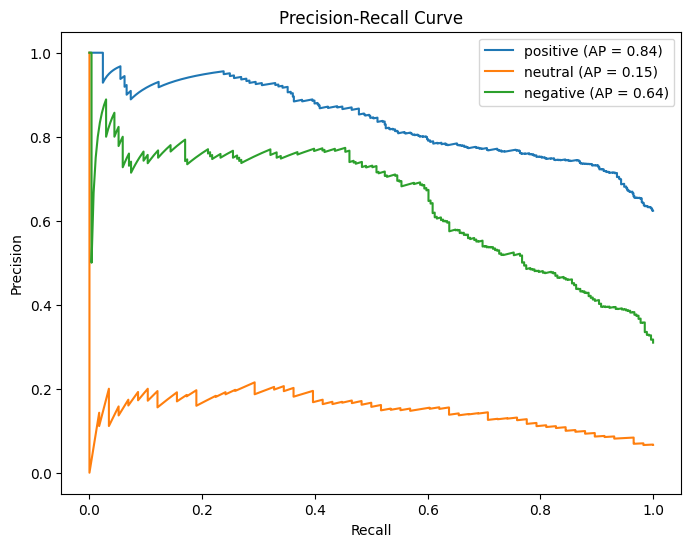

KeyError: "['Id'] not in index"

In [11]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch import nn
import torch.optim as optim
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class BLIPSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.num_classes = num_classes
        self.processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        
        for param in self.blip.parameters():
            param.requires_grad = False
            
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),  # BLIP base hidden size is 768
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image_inputs, text_inputs):
        outputs = self.blip(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            pixel_values=image_inputs['pixel_values'],
            return_dict=True
        )
        
        # Get image features
        image_features = outputs.image_embeds[:, 0]  # [CLS] token
        return self.classifier(image_features)

def process_data_batch(image_paths, texts, processor, batch_size=8, device='cuda'):
    all_image_inputs = []
    all_text_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        inputs = processor(
            images=batch_images,
            text=batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        
        all_image_inputs.append({
            'pixel_values': inputs['pixel_values'].to(device)
        })
        all_text_inputs.append({
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device)
        })
    
    return all_image_inputs, all_text_inputs

def evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device='cuda'):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            probabilities = torch.softmax(outputs, dim=1)
            all_predictions.extend(probabilities.cpu().numpy())
            all_labels.extend(test_labels[i * batch_size:(i + 1) * batch_size].cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    precision = precision_score(all_labels, predicted_labels, average='macro')
    recall = recall_score(all_labels, predicted_labels, average='macro')
    f1 = f1_score(all_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(all_labels, predicted_labels, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve
    y_test_one_hot = np.eye(len(label_map))[all_labels]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], all_predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, all_predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")

    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], all_predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, 
                device='cuda', epochs=15, batch_size=8):
    
    print("Initializing model...")
    model = BLIPSentimentModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.02)
    criterion = nn.CrossEntropyLoss()
    
    print("Processing training data...")
    train_image_inputs, train_text_inputs = process_data_batch(
        train_image_paths, train_texts, model.processor, batch_size=batch_size, device=device
    )
    
    print("Processing validation data...")
    val_image_inputs, val_text_inputs = process_data_batch(
        val_image_paths, val_texts, model.processor, batch_size=batch_size, device=device
    )
    
    train_labels = torch.tensor(train_labels, device=device)
    val_labels = torch.tensor(val_labels, device=device)
    
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(len(train_image_inputs)):
            optimizer.zero_grad()
            outputs = model(train_image_inputs[i], train_text_inputs[i])
            batch_labels = train_labels[i * batch_size:(i + 1) * batch_size]
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
        
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for i in range(len(val_image_inputs)):
                outputs = model(val_image_inputs[i], val_text_inputs[i])
                batch_labels = val_labels[i * batch_size:(i + 1) * batch_size]
                
                _, predicted = outputs.max(1)
                val_total += batch_labels.size(0)
                val_correct += predicted.eq(batch_labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        print(f'Epoch {epoch + 1}: Train Acc: {100.*correct/total:.2f}% Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def main():
    print("Installing required packages...")
    try:
        import subprocess
        subprocess.check_call(["pip", "install", "--upgrade", "transformers", "torch", "torchvision"])
    except:
        print("Warning: Could not install packages. Please ensure they are installed manually.")
        
    batch_size = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("Loading data...")
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return

    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/memosen-with-label/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())

    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Split images into train test set
    train_paths, val_paths, train_texts, val_texts, train_labs, val_labs = train_test_split(
        train_image_paths, train_df['Captions'].tolist(),
        train_labels, test_size=0.2,
        random_state=42, stratify=train_labels
    )

    # Train model
    model = train_model(
        train_paths, train_texts, train_labs,
        val_paths, val_texts, val_labs,
        device=device,
        batch_size=batch_size
    )
    
    print("Processing test data...")
    test_image_inputs, test_text_inputs = process_data_batch(
        test_image_paths, test_df['Captions'].tolist(),
        model.processor, batch_size=batch_size, device=device
    )

    # Use numeric labels directly for evaluation
    test_labels = test_labels_df['Label_Sentiment'].values  # Numeric labels
    test_labels = torch.tensor(test_labels, device=device)

    # Evaluate the model
    evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device=device)

    # Save predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predictions]
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")

if __name__ == "__main__":
    main()

In [ ]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoProcessor, BlipForConditionalGeneration
from torch import nn
import torch.optim as optim
from PIL import Image
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def get_image_paths(directory, image_names):
    """Get full paths for images"""
    image_paths = {img: os.path.join(directory, img) for img in image_names}
    return [image_paths[img] for img in image_names if img in image_paths]

class BLIPSentimentModel(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.num_classes = num_classes
        self.processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
        self.blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
        
        for param in self.blip.parameters():
            param.requires_grad = False
            
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),  # BLIP base hidden size is 768
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.LayerNorm(512),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image_inputs, text_inputs):
        outputs = self.blip(
            input_ids=text_inputs['input_ids'],
            attention_mask=text_inputs['attention_mask'],
            pixel_values=image_inputs['pixel_values'],
            return_dict=True
        )
        
        # Get image features
        image_features = outputs.image_embeds[:, 0]  # [CLS] token
        return self.classifier(image_features)

def process_data_batch(image_paths, texts, processor, batch_size=8, device='cuda'):
    all_image_inputs = []
    all_text_inputs = []
    
    for i in range(0, len(image_paths), batch_size):
        batch_images = []
        batch_texts = texts[i:i + batch_size]
        
        for path in image_paths[i:i + batch_size]:
            try:
                image = Image.open(path).convert('RGB')
                batch_images.append(image)
            except Exception as e:
                print(f"Error loading image {path}: {str(e)}")
                batch_images.append(Image.new('RGB', (224, 224), color='black'))
        
        inputs = processor(
            images=batch_images,
            text=batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77
        )
        
        all_image_inputs.append({
            'pixel_values': inputs['pixel_values'].to(device)
        })
        all_text_inputs.append({
            'input_ids': inputs['input_ids'].to(device),
            'attention_mask': inputs['attention_mask'].to(device)
        })
    
    return all_image_inputs, all_text_inputs

def evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device='cuda'):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            probabilities = torch.softmax(outputs, dim=1)
            all_predictions.extend(probabilities.cpu().numpy())
            all_labels.extend(test_labels[i * batch_size:(i + 1) * batch_size].cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predicted_labels = np.argmax(all_predictions, axis=1)

    # Calculate metrics
    precision = precision_score(all_labels, predicted_labels, average='macro')
    recall = recall_score(all_labels, predicted_labels, average='macro')
    f1 = f1_score(all_labels, predicted_labels, average='macro')
    weighted_f1 = f1_score(all_labels, predicted_labels, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Weighted F1-Score: {weighted_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC-AUC Curve
    y_test_one_hot = np.eye(len(label_map))[all_labels]
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i, label in enumerate(label_map.keys()):
        fpr[label], tpr[label], _ = roc_curve(y_test_one_hot[:, i], all_predictions[:, i])
        roc_auc[label] = auc(fpr[label], tpr[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(fpr[label], tpr[label], label=f'{label} (AUC = {roc_auc[label]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # ROC-AUC Score (macro-average)
    roc_auc_macro = roc_auc_score(y_test_one_hot, all_predictions, multi_class='ovr', average='macro')
    print(f"Macro-average ROC-AUC Score: {roc_auc_macro:.4f}")

    # Precision-Recall Curve
    precision_dict = {}
    recall_dict = {}
    average_precision_dict = {}
    for i, label in enumerate(label_map.keys()):
        precision_dict[label], recall_dict[label], _ = precision_recall_curve(y_test_one_hot[:, i], all_predictions[:, i])
        average_precision_dict[label] = auc(recall_dict[label], precision_dict[label])

    plt.figure(figsize=(8, 6))
    for label in label_map.keys():
        plt.plot(recall_dict[label], precision_dict[label], label=f'{label} (AP = {average_precision_dict[label]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def train_model(train_image_paths, train_texts, train_labels, 
                val_image_paths, val_texts, val_labels, 
                device='cuda', epochs=15, batch_size=8):
    
    print("Initializing model...")
    model = BLIPSentimentModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.02)
    criterion = nn.CrossEntropyLoss()
    
    print("Processing training data...")
    train_image_inputs, train_text_inputs = process_data_batch(
        train_image_paths, train_texts, model.processor, batch_size=batch_size, device=device
    )
    
    print("Processing validation data...")
    val_image_inputs, val_text_inputs = process_data_batch(
        val_image_paths, val_texts, model.processor, batch_size=batch_size, device=device
    )
    
    train_labels = torch.tensor(train_labels, device=device)
    val_labels = torch.tensor(val_labels, device=device)
    
    best_val_acc = 0
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for i in range(len(train_image_inputs)):
            optimizer.zero_grad()
            outputs = model(train_image_inputs[i], train_text_inputs[i])
            batch_labels = train_labels[i * batch_size:(i + 1) * batch_size]
            
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()
        
        model.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for i in range(len(val_image_inputs)):
                outputs = model(val_image_inputs[i], val_text_inputs[i])
                batch_labels = val_labels[i * batch_size:(i + 1) * batch_size]
                
                _, predicted = outputs.max(1)
                val_total += batch_labels.size(0)
                val_correct += predicted.eq(batch_labels).sum().item()
        
        val_acc = 100. * val_correct / val_total
        print(f'Epoch {epoch + 1}: Train Acc: {100.*correct/total:.2f}% Val Acc: {val_acc:.2f}%')
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def main():
    print("Installing required packages...")
    try:
        import subprocess
        subprocess.check_call(["pip", "install", "--upgrade", "transformers", "torch", "torchvision"])
    except:
        print("Warning: Could not install packages. Please ensure they are installed manually.")
        
    batch_size = 8
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    print("Loading data...")
    # Load the combined dataset
    try:
        combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='utf-8')
    except UnicodeDecodeError:
        try:
            combined_df = pd.read_csv('/kaggle/input/memosen-with-label/multi-sent.csv', encoding='latin-1')
        except Exception as e:
            print(f"Failed to read the CSV file: {e}")
            return

    # Debug: Print column names to verify
    print("Combined DataFrame Columns:", combined_df.columns)
    
    # Ensure the label column exists
    if 'Label_Sentiment' not in combined_df.columns:
        raise KeyError("Column 'Label_Sentiment' not found in the combined dataset. Please check the column names.")
    
    # Check for missing or invalid values in the 'Label_Sentiment' column
    print("Number of missing values in 'Label_Sentiment':", combined_df['Label_Sentiment'].isna().sum())
    print("Unique values in 'Label_Sentiment':", combined_df['Label_Sentiment'].unique())
    
    # Drop rows with missing or invalid labels
    valid_labels = ['positive', 'neutral', 'negative']
    combined_df = combined_df[combined_df['Label_Sentiment'].isin(valid_labels)]
    
    # Check if the dataset is empty after cleaning
    if combined_df.empty:
        raise ValueError("The dataset is empty after removing rows with invalid labels.")
    
    # Convert labels to numerical values
    label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
    combined_df['Label_Sentiment'] = combined_df['Label_Sentiment'].map(label_map)
    
    # Split the data into train and test sets (80-20 ratio)
    train_df, test_df = train_test_split(
        combined_df, test_size=0.2, random_state=42, stratify=combined_df['Label_Sentiment']
    )
    
    # Copy the labels of the test set for evaluation
    test_labels_df = test_df[['Label_Sentiment']].copy()
    
    # Drop the labels from the test set to simulate unseen data
    test_df = test_df.drop(columns=['Label_Sentiment'])
    
    # Get image paths
    memes_folder = '/kaggle/input/memosen-with-label/Memes'
    train_image_paths = get_image_paths(memes_folder, train_df['image_name'].tolist())
    test_image_paths = get_image_paths(memes_folder, test_df['image_name'].tolist())

    # Extract labels
    train_labels = train_df['Label_Sentiment'].values
    test_labels = test_labels_df['Label_Sentiment'].values

    # Split images into train test set
    train_paths, val_paths, train_texts, val_texts, train_labs, val_labs = train_test_split(
        train_image_paths, train_df['Captions'].tolist(),
        train_labels, test_size=0.2,
        random_state=42, stratify=train_labels
    )

    # Train model
    model = train_model(
        train_paths, train_texts, train_labs,
        val_paths, val_texts, val_labs,
        device=device,
        batch_size=batch_size
    )
    
    print("Processing test data...")
    test_image_inputs, test_text_inputs = process_data_batch(
        test_image_paths, test_df['Captions'].tolist(),
        model.processor, batch_size=batch_size, device=device
    )

    # Use numeric labels directly for evaluation
    test_labels = test_labels_df['Label_Sentiment'].values  # Numeric labels
    test_labels = torch.tensor(test_labels, device=device)

    # Evaluate the model
    evaluate_model(model, test_image_inputs, test_text_inputs, test_labels, label_map, batch_size, device=device)

    # Save predictions
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(test_image_inputs)):
            outputs = model(test_image_inputs[i], test_text_inputs[i])
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())

    reverse_label_map = {v: k for k, v in label_map.items()}
    test_df['Label'] = [reverse_label_map[label] for label in predictions]

    # Add an 'Id' column if it doesn't exist
    if 'Id' not in test_df.columns:
        test_df['Id'] = test_df['image_name']  # Use 'image_name' as the 'Id' column
        
    test_df[['Id', 'Label']].to_csv('submission.csv', index=False)
    print("Predictions saved to submission.csv")

if __name__ == "__main__":
    main()